In [1]:
from astropy.io import fits
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.utils.data import get_pkg_data_filename
from astropy.convolution import convolve, Gaussian1DKernel
import pyspeckit
from scipy.ndimage import convolve

In [2]:
espc = fits.open('DataDESI_691_752.fits') #open file
wave= fits.open('B_R_Z_wavelenght.fits')
espc.info() #resume el contenido de la tabla
wave.info()

Filename: DataDESI_691_752.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     26   89878R x 9C   [7A, D, D, 7A, D, 21A, D, D, 7A]   
  2  B_FLUX        1 ImageHDU         8   (2751, 89878)   float32   
  3  R_FLUX        1 ImageHDU         8   (2326, 89878)   float32   
  4  Z_FLUX        1 ImageHDU         8   (2881, 89878)   float32   
Filename: B_R_Z_wavelenght.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  B_WAVELENGHT    1 ImageHDU         7   (2751,)   float64   
  2  R_WAVELENGHT    1 ImageHDU         7   (2326,)   float64   
  3  Z_WAVELENGHT    1 ImageHDU         7   (2881,)   float64   


In [4]:
flux_b=espc[2].data
flux_r=espc[3].data
flux_z=espc[4].data

In [5]:
len(flux_z)

89878

In [6]:
len(flux_z[0])

2881

In [7]:
i=-3
espectro_1_b=flux_b[i]
espectro_1_r=flux_r[i]
espectro_1_z=flux_z[i]

espectro_1=np.hstack((espectro_1_b, espectro_1_r, espectro_1_z))

In [8]:
espectro_1

array([-3.0887322,  3.9484348,  9.715307 , ...,  1.6537042,  1.3760386,
        2.2182627], dtype=float32)

In [9]:
len(espectro_1)

7958

In [10]:
Bwave = wave[1].data
Rwave = wave[2].data
Zwave = wave[3].data

In [11]:
wavelenght = np.hstack((Bwave, Rwave, Zwave)) #Contiene la cadena completa de longitudes de onda B+Z+R para cada espectro


In [14]:
wavelenght

array([3600. , 3600.8, 3601.6, ..., 9822.4, 9823.2, 9824. ])

In [15]:
len(wavelenght)

7958

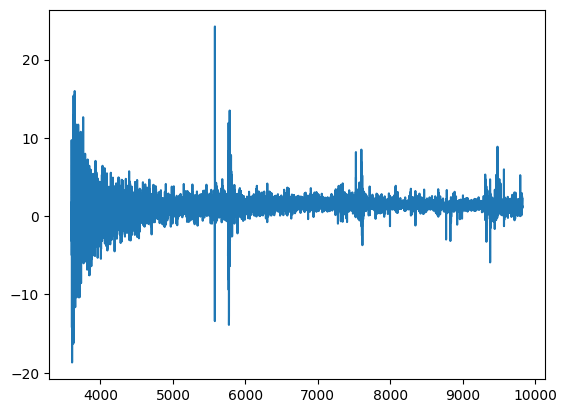

In [16]:
plt.figure()
plt.plot(wavelenght, espectro_1)
plt.show()

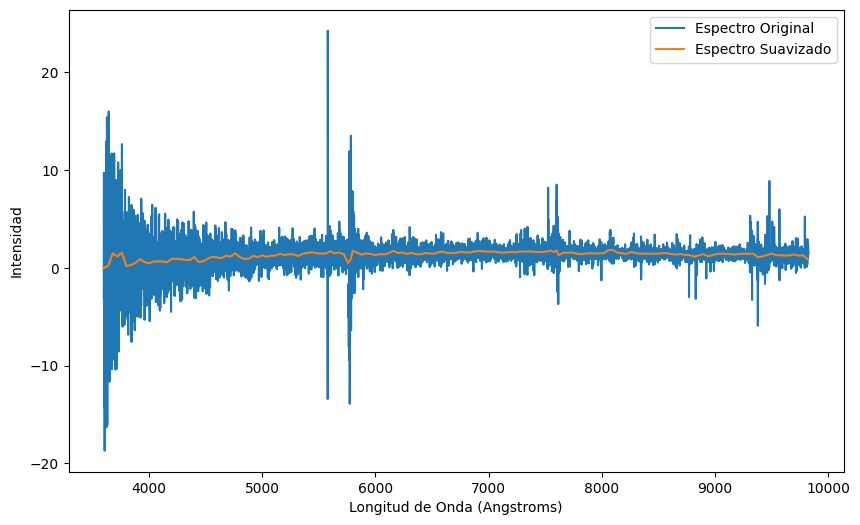

In [25]:
# Crea una instancia de la clase Spectrum
sp = pyspeckit.Spectrum(data=espectro_1, xarr=wavelenght, xarrkwargs={'unit':'angstroms'})

# Realiza un suavizado utilizando el método smooth con un ancho de ventana específico
sp.smooth(50)  # Ajusta el valor de beam_radius según tus necesidades

# Grafica el espectro original y el suavizado
plt.figure(figsize=(10, 6))
plt.plot(wavelenght, espectro_1, label='Espectro Original')
plt.plot(sp.xarr, sp.data, label='Espectro Suavizado')
plt.xlabel('Longitud de Onda (Angstroms)')
plt.ylabel('Intensidad')
plt.legend()
plt.show()

Pico - Amplitud: 2.267087350108268, Longitud de Onda: 3696.000000000022 Angstrom, Ancho Medio: 1716.0000000003902 Angstrom
Pico - Amplitud: 2.7680972491806948, Longitud de Onda: 3756.0000000000355 Angstrom, Ancho Medio: 5834.400000000435 Angstrom
Pico - Amplitud: 1.7263652605201747, Longitud de Onda: 4680.000000000246 Angstrom, Ancho Medio: 276.00000000006276 Angstrom
Pico - Amplitud: 1.8262074066849447, Longitud de Onda: 4764.000000000265 Angstrom, Ancho Medio: 444.00000000010095 Angstrom
Pico - Amplitud: 1.7091225374355168, Longitud de Onda: 5268.000000000379 Angstrom, Ancho Medio: 5066.40000000026 Angstrom
Pico - Amplitud: 1.7222283886937768, Longitud de Onda: 5448.00000000042 Angstrom, Ancho Medio: 4538.40000000014 Angstrom
Pico - Amplitud: 1.9634894060541908, Longitud de Onda: 5580.00000000045 Angstrom, Ancho Medio: 3998.400000000018 Angstrom
Pico - Amplitud: 1.8117092303473177, Longitud de Onda: 5604.000000000456 Angstrom, Ancho Medio: 5474.4000000003525 Angstrom
Pico - Amplitud:

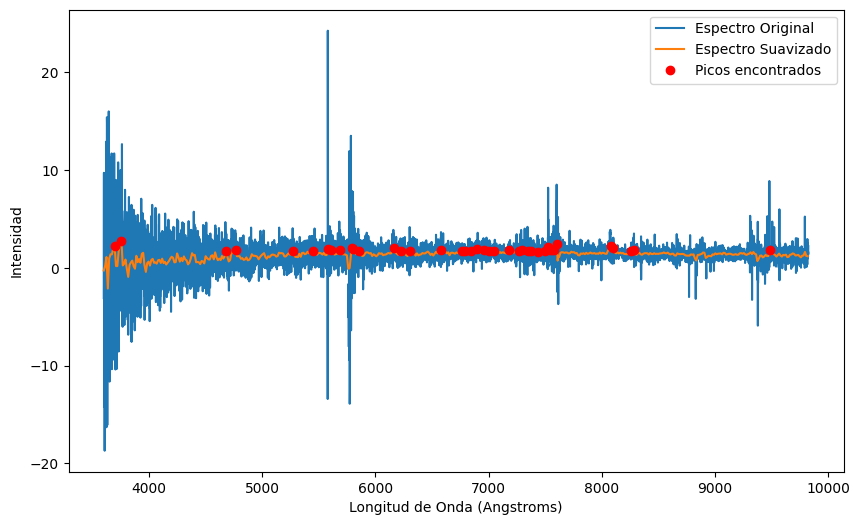

In [26]:
import pyspeckit
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

# Crea una instancia de la clase Spectrum
sp = pyspeckit.Spectrum(data=espectro_1, xarr=wavelenght, xarrkwargs={'unit':'angstroms'})

# Realiza un suavizado utilizando el método smooth con un ancho de ventana específico
sp.smooth(15)  # Ajusta el valor según tus necesidades

# Encuentra los máximos locales en el espectro suavizado
#peaks, _ = find_peaks(sp.data)

# Encuentra los máximos locales en el espectro suavizado considerando solo los picos significativos
peaks, _ = find_peaks(sp.data, height=0.6 * np.max(sp.data))  # Ajusta el umbral según tus necesidades


# Define una función para encontrar el ancho medio
def half_width(x, y, peak_index):
    half_height = y[peak_index] / 2.0
    
    # Encuentra los índices donde el suavizado cruza la mitad de la altura del pico
    left_index = np.argmin(np.abs(y[:peak_index] - half_height))
    right_index = np.argmin(np.abs(y[peak_index:] - half_height)) + peak_index
    
    # Calcula la longitud de onda correspondiente a esos índices
    left_wavelength = x[left_index]
    right_wavelength = x[right_index]
    
    # Calcula el ancho medio
    width = right_wavelength - left_wavelength
    
    return width

# Imprime información sobre los picos encontrados
for peak_index in peaks:
    amplitude = sp.data[peak_index]  # Amplitud del pico
    wavelength_at_peak = sp.xarr[peak_index]  # Longitud de onda en el pico
    width = half_width(sp.xarr, sp.data, peak_index)  # Ancho medio
    
    print(f"Pico - Amplitud: {amplitude}, Longitud de Onda: {wavelength_at_peak}, Ancho Medio: {width}")


# Grafica el espectro original, el suavizado y los picos encontrados
plt.figure(figsize=(10, 6))
plt.plot(wavelenght, espectro_1, label='Espectro Original')
plt.plot(sp.xarr, sp.data, label='Espectro Suavizado')
plt.plot(sp.xarr[peaks], sp.data[peaks], 'ro', label='Picos encontrados')
plt.xlabel('Longitud de Onda (Angstroms)')
plt.ylabel('Intensidad')
plt.legend()
plt.show()

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7958 [pyspeckit.spectrum.interactive]


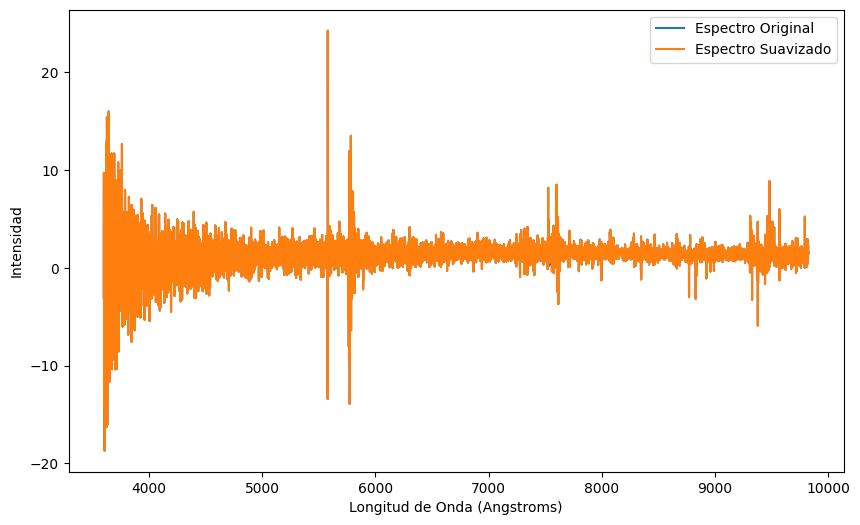

In [16]:
# Crea una instancia de la clase Spectrum
sp = pyspeckit.Spectrum(data=espectro_1, xarr=wavelenght, xarrkwargs={'unit':'angstroms'})


# Ajusta el suavizado utilizando una función Lorentziana
sp.specfit(fittype='lorentzian', guesses=[25, 10, 1])

# Grafica el espectro original y el suavizado
plt.figure(figsize=(10, 6))
plt.plot(wavelenght, espectro_1, label='Espectro Original')
plt.plot(sp.xarr, sp.data, label='Espectro Suavizado')
plt.xlabel('Longitud de Onda (Angstroms)')
plt.ylabel('Intensidad')
plt.legend()
plt.show()

In [17]:
from lmfit import Model
import lmfit

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 7958
    # variables        = 3
    chi-square         = 18616.4831
    reduced chi-square = 2.34022415
    Akaike info crit   = 6769.26280
    Bayesian info crit = 6790.20860
    R-squared          = 0.02982384
[[Variables]]
    amp:  1.61827998 +/- 0.02694982 (1.67%) (init = 24.24002)
    cen:  7399.07328 +/- 81.6576281 (1.10%) (init = 3600)
    wid:  2897.58661 +/- 125.513726 (4.33%) (init = 7)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.6352
    C(cen, wid) = +0.5012
    C(amp, cen) = -0.1869


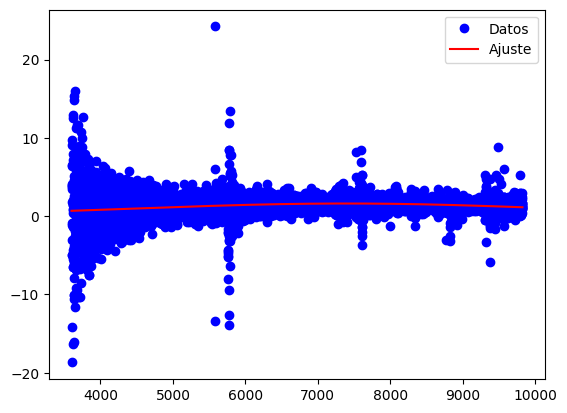

In [18]:
# Crear datos de prueba (reemplaza esto con tus propios datos)
# Supongamos que tienes una lista unidimensional llamada 'flujo'
flujo = espectro_1  # Datos de flujo aleatorios para el ejemplo

# Crear un objeto xarr basado en el número de puntos de datos
xarr = wavelenght

# Modelo gaussiano para el ajuste
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

# Crear el modelo
modelo = lmfit.Model(gaussian)

# Crear parámetros iniciales
#params = modelo.make_params(amp=1, cen=len(xarr) / 2, wid=1)
params = modelo.make_params(amp=np.max(flujo), cen=np.argmax(flujo), wid=7)
params['amp'].min = 0  # La amplitud debe ser positiva
params['cen'].min = min(xarr)  # El centro debe ser mayor que el valor mínimo de xarr
params['cen'].max = max(xarr)  # El centro debe ser menor que el valor máximo de xarr
params['wid'].min = 0  # La anchura debe ser positiva

# Realizar el ajuste
resultado = modelo.fit(flujo, params, x=xarr)

# Obtener los resultados del ajuste
print(resultado.fit_report())

# Plotear los resultados
plt.plot(xarr, flujo, 'bo', label='Datos')
plt.plot(xarr, resultado.best_fit, 'r-', label='Ajuste')
plt.legend()
plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 7958
    # variables        = 3
    chi-square         = 18616.4831
    reduced chi-square = 2.34022415
    Akaike info crit   = 6769.26280
    Bayesian info crit = 6790.20860
    R-squared          = 0.02982384
[[Variables]]
    amp:  1.61828133 +/- 0.02693235 (1.66%) (init = 24.24002)
    cen:  7399.06540 +/- 81.6741958 (1.10%) (init = 3600)
    wid:  2897.57490 +/- 125.400675 (4.33%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.6340
    C(cen, wid) = +0.5000
    C(amp, cen) = -0.1833


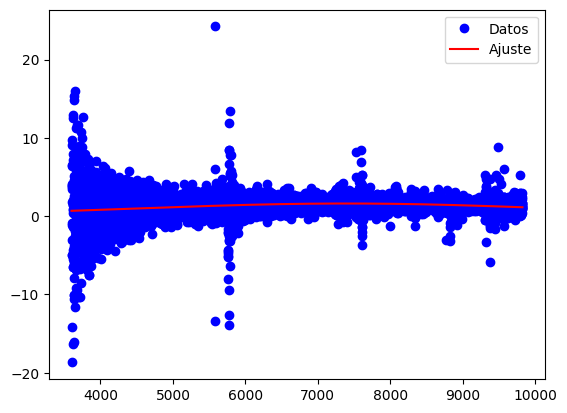

In [19]:
# Crear datos de prueba (reemplaza esto con tus propios datos)
# Supongamos que tienes una lista unidimensional llamada 'flujo'
flujo = espectro_1  # Datos de flujo aleatorios para el ejemplo

# Crear un objeto xarr basado en el número de puntos de datos
xarr = wavelenght

# Modelo gaussiano para el ajuste
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

# Crear el modelo
modelo = lmfit.Model(gaussian)

# Crear parámetros iniciales
#params = modelo.make_params(amp=1, cen=len(xarr) / 2, wid=1)
params = modelo.make_params(amp=np.max(flujo), cen=np.argmax(flujo), wid=10)
params['amp'].min = 0  # La amplitud debe ser positiva
params['cen'].min = min(xarr)  # El centro debe ser mayor que el valor mínimo de xarr
params['cen'].max = max(xarr)  # El centro debe ser menor que el valor máximo de xarr
params['wid'].min = 0  # La anchura debe ser positiva

# Realizar el ajuste
resultado = modelo.fit(flujo, params, x=xarr, method='leastsq')

# Obtener los resultados del ajuste
print(resultado.fit_report())

# Plotear los resultados
plt.plot(xarr, flujo, 'bo', label='Datos')
plt.plot(xarr, resultado.best_fit, 'r-', label='Ajuste')
plt.legend()
plt.show()

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7958 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7958 [pyspeckit.spectrum.interactive]
Parámetros del ajuste: [1.6182808593531333, 7399.070096799816, 2897.5793988323217]


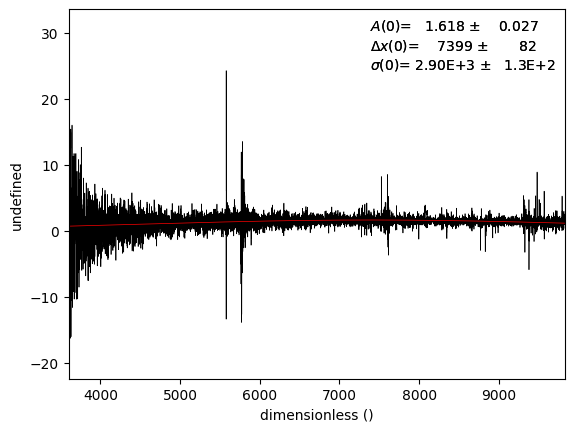

In [20]:
# Crear una instancia de Spectrum con los datos de flujo y el objeto xarr
espectro = pyspeckit.Spectrum(data=flujo, xarr=xarr)

# Configurar el tipo de ajuste (por ejemplo, gaussiana) y habilitar multifit
espectro.specfit(fittype='gaussian', multifit=True)

# Establecer límites para el número de componentes
espectro.specfit.parlimits = {2: (0, None), 5: (0, None)}  # Permite amplitudes positivas

ancho_ventana = 15  # Ajusta según tus necesidades
espectro.specfit(smoothtype='welch', smoothwidth=ancho_ventana)

# Obtener los parámetros del ajuste
params = espectro.specfit.modelpars
print("Parámetros del ajuste:", params)

# Plotear el espectro original y el ajuste
espectro.plotter()
espectro.specfit.plot_fit()
plt.show()

In [21]:
from lmfit.models import GaussianModel
x=wavelenght
y=espectro_1

mod = GaussianModel()
pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 7958
    # variables        = 3
    chi-square         = 18616.4831
    reduced chi-square = 2.34022415
    Akaike info crit   = 6769.26280
    Bayesian info crit = 6790.20860
    R-squared          = 0.02982384
[[Variables]]
    amplitude:  11753.8176 +/- 413.380532 (3.52%) (init = 400277.7)
    center:     7399.06790 +/- 81.6645580 (1.10%) (init = 5334.673)
    sigma:      2897.57759 +/- 125.452019 (4.33%) (init = 3107.6)
    fwhm:       6823.27356 +/- 295.416922 (4.33%) == '2.3548200*sigma'
    height:     1.61828112 +/- 0.02693970 (1.66%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma)  = +0.9307
    C(amplitude, center) = +0.5287
    C(center, sigma)     = +0.5005


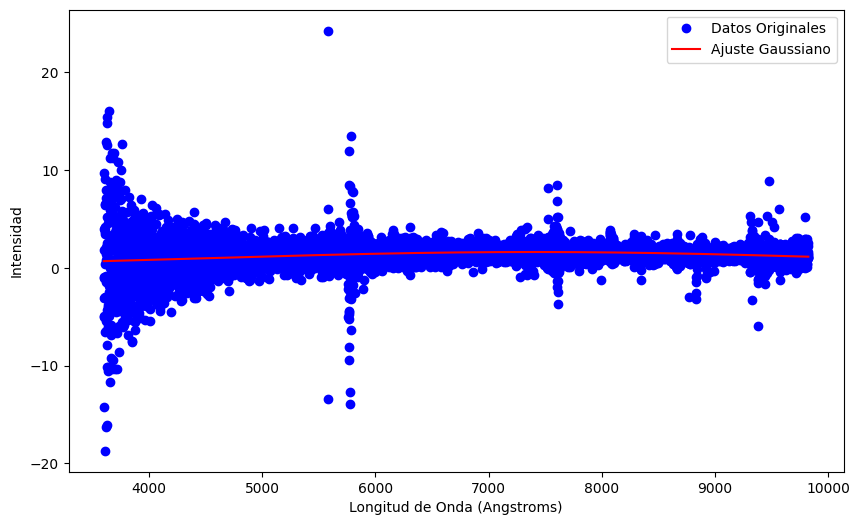

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='Datos Originales')
plt.plot(x, out.best_fit, 'r-', label='Ajuste Gaussiano')
plt.xlabel('Longitud de Onda (Angstroms)')
plt.ylabel('Intensidad')
plt.legend()
plt.show()

In [23]:
from lmfit.models import LorentzianModel

mod = LorentzianModel()
pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 7958
    # variables        = 3
    chi-square         = 18633.3037
    reduced chi-square = 2.34233862
    Akaike info crit   = 6776.44988
    Bayesian info crit = 6797.39568
    R-squared          = 0.02894725
[[Variables]]
    amplitude:  18603.7638 +/- 775.517334 (4.17%) (init = 500347.1)
    center:     7410.25821 +/- 81.0770505 (1.09%) (init = 5334.673)
    sigma:      3623.49216 +/- 189.438802 (5.23%) (init = 3107.6)
    fwhm:       7246.98422 +/- 378.877604 (5.23%) == '2.0000000*sigma'
    height:     1.63426938 +/- 0.02939739 (1.80%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma)  = +0.9515
    C(amplitude, center) = +0.4064
    C(center, sigma)     = +0.3750


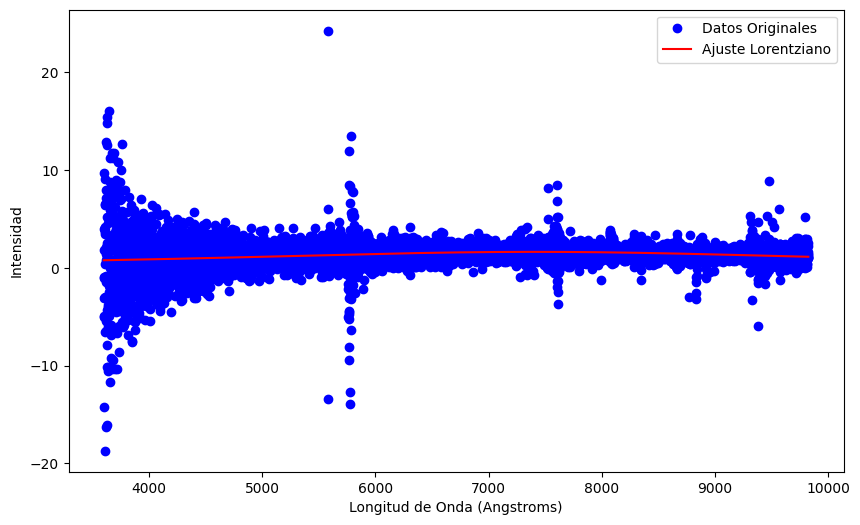

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='Datos Originales')
plt.plot(x, out.best_fit, 'r-', label='Ajuste Lorentziano')
plt.xlabel('Longitud de Onda (Angstroms)')
plt.ylabel('Intensidad')
plt.legend()
plt.show()

In [25]:
from lmfit.models import VoigtModel

mod = VoigtModel()
pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(voigt)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 7958
    # variables        = 3
    chi-square         = 18621.2206
    reduced chi-square = 2.34081968
    Akaike info crit   = 6771.28767
    Bayesian info crit = 6792.23347
    R-squared          = 0.02957695
[[Variables]]
    amplitude:  14986.9817 +/- 556.000378 (3.71%) (init = 600416.6)
    center:     7403.15180 +/- 81.1958709 (1.10%) (init = 5334.673)
    sigma:      1926.85175 +/- 88.7542264 (4.61%) (init = 2019.94)
    gamma:      1926.85172 +/- 88.7542266 (4.61%) == 'sigma'
    fwhm:       6939.15306 +/- 319.629766 (4.61%) == '1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'
    height:     1.62333309 +/- 0.02773168 (1.71%) == '(amplitude/(max(1e-15, sigma*sqrt(2*pi))))*real(wofz((1j*gamma)/(max(1e-15, sigma*sqrt(2)))))'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma)  = +0.9381
    C(amplitude, center) = +0.4

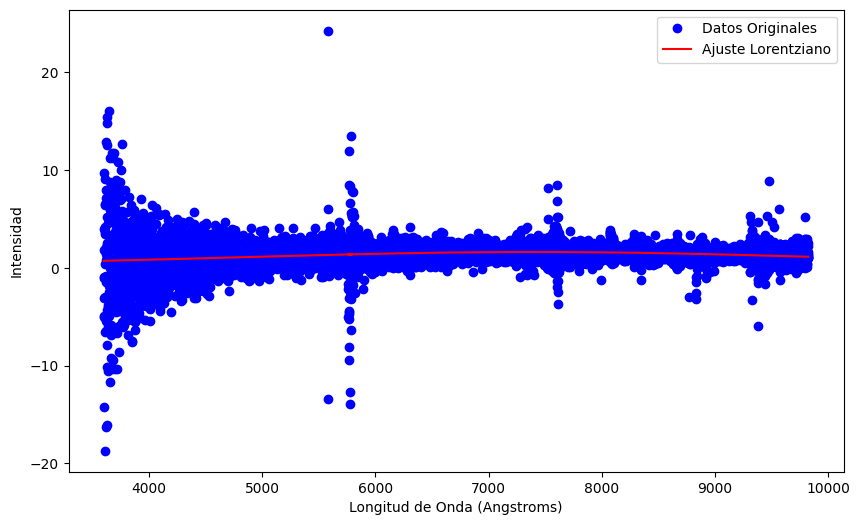

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='Datos Originales')
plt.plot(x, out.best_fit, 'r-', label='Ajuste Lorentziano')
plt.xlabel('Longitud de Onda (Angstroms)')
plt.ylabel('Intensidad')
plt.legend()
plt.show()

[[Model]]
    (Model(step, prefix='step_', form='erf') + Model(linear, prefix='line_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 7958
    # variables        = 5
    chi-square         = 18950.0486
    reduced chi-square = 2.38275476
    Akaike info crit   = 6914.58987
    Bayesian info crit = 6949.49953
    R-squared          = 0.01244046
[[Variables]]
    line_slope:      9.7210e-05 +/- 1.7020e-05 (17.51%) (init = 0)
    line_intercept:  0.67990598 +/- 159747.514 (23495530.21%) (init = -18.69534)
    step_amplitude: -10.1677704 +/- 1.3495e+10 (132718568085.11%) (init = 42.93535)
    step_center:     2.6760e+11 +/- 2.0695e+20 (77336351773.02%) (init = 24.24002)
    step_sigma:      7.7299e+10 +/- 5.8383e+19 (75528883528.84%) (init = 889.1429)
[[Correlations]] (unreported correlations are < 0.100)
    C(line_intercept, step_sigma)  = +0.8458
    C(line_intercept, step_center) = -0.8409
    C(line_slope, line_intercept)  = +

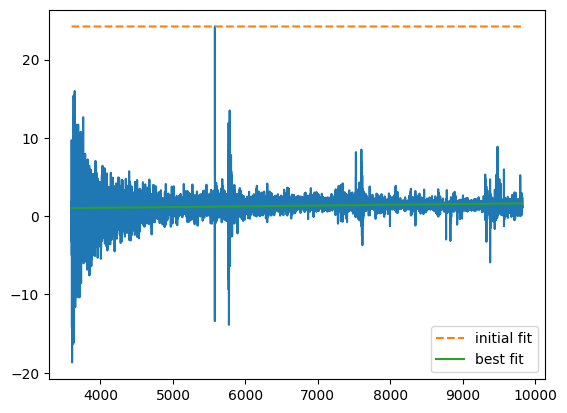

In [27]:
from lmfit.models import LinearModel, StepModel
step_mod = StepModel(form='erf', prefix='step_')
line_mod = LinearModel(prefix='line_')

pars = line_mod.make_params(intercept=y.min(), slope=0)
pars += step_mod.guess(y, x=x, center=np.max(y))

mod = step_mod + line_mod
out = mod.fit(y, pars, x=x)

print(out.fit_report())

plt.plot(x, y)
plt.plot(x, out.init_fit, '--', label='initial fit')
plt.plot(x, out.best_fit, '-', label='best fit')
plt.legend()
plt.show()

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 7958
    # variables        = 1
    chi-square         = 19188.7657
    reduced chi-square = 2.41155784
    Akaike info crit   = 7006.21202
    Bayesian info crit = 7013.19395
    R-squared          = 2.2204e-16
[[Variables]]
    c:  1.33311952 +/- 0.01740792 (1.31%) (init = 1.33312)


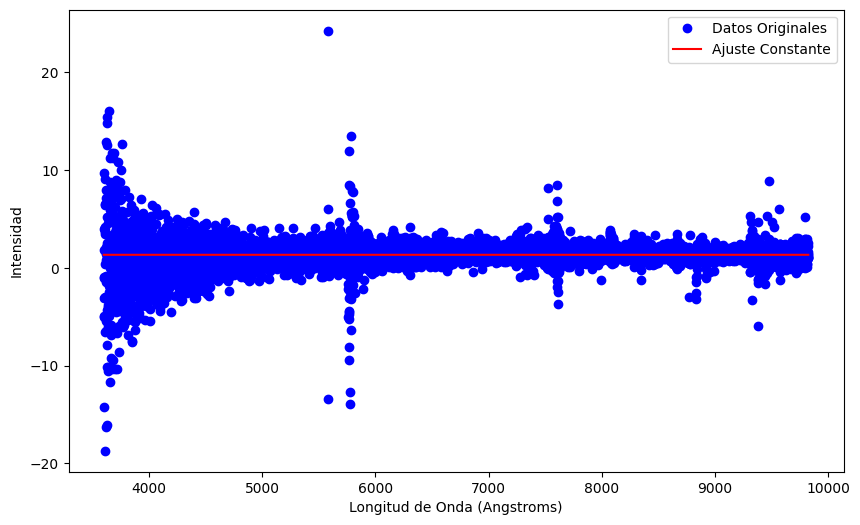

In [28]:
from lmfit.models import ConstantModel

# Supongamos que tienes tus datos de longitud de onda y espectro
x = wavelenght
y = espectro_1

# Crear un modelo constante
mod = ConstantModel()

# Ajustar el modelo
pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

# Imprimir el reporte del ajuste
print(out.fit_report(min_correl=0.25))

# Graficar los datos originales y el ajuste
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='Datos Originales')
plt.plot(x, out.best_fit, 'r-', label='Ajuste Constante')
plt.xlabel('Longitud de Onda (Angstroms)')
plt.ylabel('Intensidad')
plt.legend()
plt.show()

In [2]:
from scipy.signal import savgol_filter

# Supongamos que tienes tus datos de longitud de onda y espectro
x = wavelenght
y = espectro_1

# Aplicar el filtro Savitzky-Golay para suavizar
y_suavizado = savgol_filter(y, window_length=100, polyorder=5)

# Graficar los datos originales y el suavizado
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='Datos Originales')
plt.plot(x, y_suavizado, 'r-', label='Suavizado Savitzky-Golay')
plt.xlabel('Longitud de Onda (Angstroms)')
plt.ylabel('Intensidad')
plt.legend()
plt.show()


NameError: name 'wavelenght' is not defined

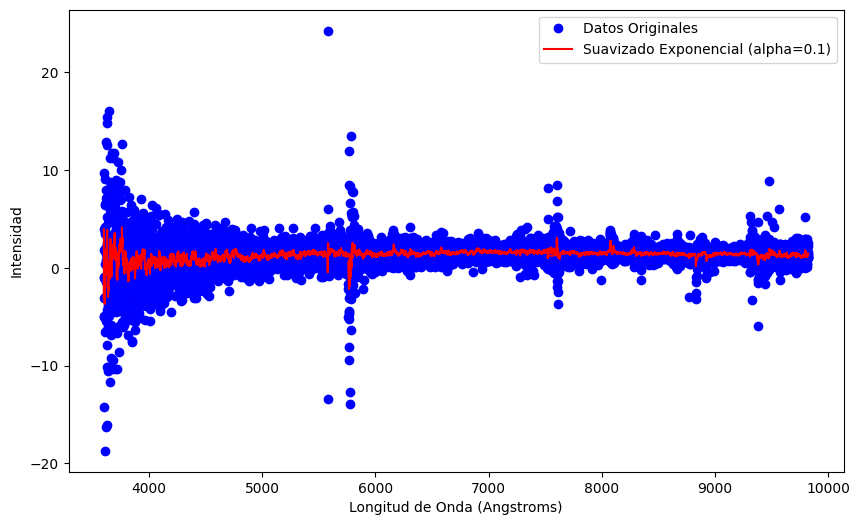

In [54]:
import pandas as pd

# Supongamos que tienes tus datos de longitud de onda y espectro
x = wavelenght
y = espectro_1

# Crear un DataFrame con los datos
data = pd.DataFrame({'x': x, 'y': y})

# Aplicar un filtro exponencial para suavizar
alpha = 0.1  # Ajusta según tus necesidades
data['y_suavizado'] = data['y'].ewm(alpha=alpha).mean()

# Graficar los datos originales y el suavizado
plt.figure(figsize=(10, 6))
plt.plot(data['x'], data['y'], 'bo', label='Datos Originales')
plt.plot(data['x'], data['y_suavizado'], 'r-', label=f'Suavizado Exponencial (alpha={alpha})')
plt.xlabel('Longitud de Onda (Angstroms)')
plt.ylabel('Intensidad')
plt.legend()
plt.show()

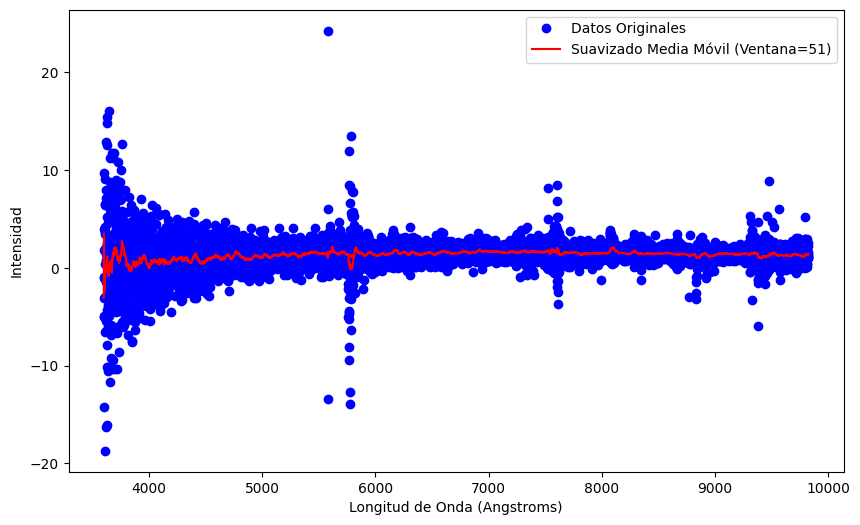

In [36]:
# Supongamos que tienes tus datos de longitud de onda y espectro
x = wavelenght
y = espectro_1

# Aplicar una media móvil para suavizar
ventana = 51  # Ajusta según tus necesidades
y_suavizado = pd.Series(y).rolling(window=ventana, min_periods=1).mean()

# Graficar los datos originales y el suavizado
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='Datos Originales')
plt.plot(x, y_suavizado, 'r-', label=f'Suavizado Media Móvil (Ventana={ventana})')
plt.xlabel('Longitud de Onda (Angstroms)')
plt.ylabel('Intensidad')
plt.legend()
plt.show()


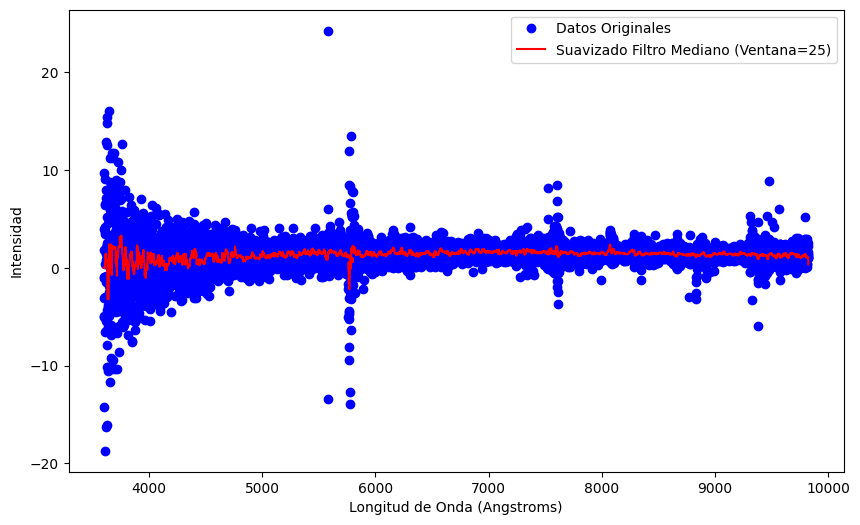

In [59]:
from scipy.signal import medfilt

# Supongamos que tienes tus datos de longitud de onda y espectro
x = wavelenght
y = espectro_1

# Aplicar un filtro mediano para suavizar
ventana = 25  # Ajusta según tus necesidades
y_suavizado = medfilt(y, kernel_size=ventana)

# Graficar los datos originales y el suavizado
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='Datos Originales')
plt.plot(x, y_suavizado, 'r-', label=f'Suavizado Filtro Mediano (Ventana={ventana})')
plt.xlabel('Longitud de Onda (Angstroms)')
plt.ylabel('Intensidad')
plt.legend()
plt.show()


In [33]:
import pywt

# Supongamos que tienes tus datos de longitud de onda y espectro
x = wavelenght
y = espectro_1

# Aplicar una transformada wavelet y suavizar
coeffs = pywt.wavedec(y, 'db1', level=5)
y_suavizado = pywt.waverec(coeffs, 'db1')

# Graficar los datos originales y el suavizado
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='Datos Originales')
plt.plot(x, y_suavizado, 'r-', label='Suavizado con Wavelet')
plt.xlabel('Longitud de Onda (Angstroms)')
plt.ylabel('Intensidad')
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'pywt'

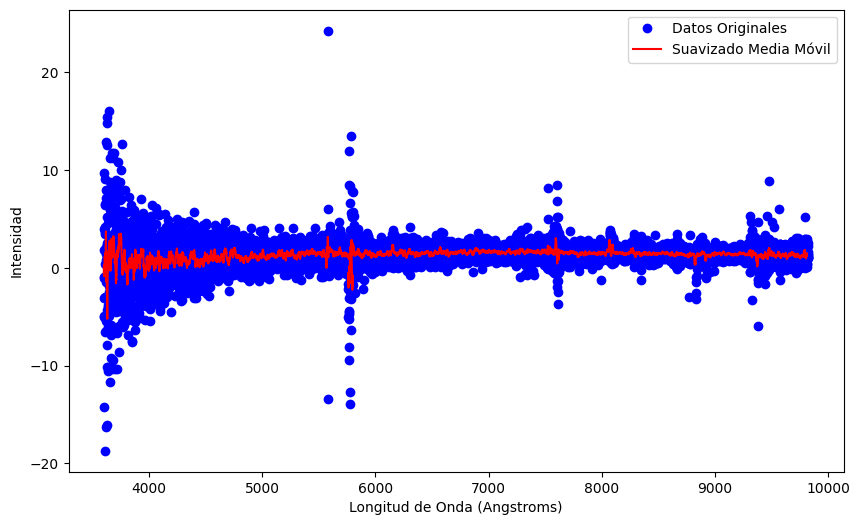

In [62]:
# Supongamos que tienes tus datos de longitud de onda y espectro
x = wavelenght
y = espectro_1

# Aplicar una media móvil para suavizar
ventana = 15  # Ajusta según tus necesidades
y_suavizado = np.convolve(y, np.ones(ventana)/ventana, mode='valid')

# Graficar los datos originales y el suavizado
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='Datos Originales')
plt.plot(x[:len(y_suavizado)], y_suavizado, 'r-', label='Suavizado Media Móvil')
plt.xlabel('Longitud de Onda (Angstroms)')
plt.ylabel('Intensidad')
plt.legend()
plt.show()

In [ ]:
espectro_1=espectro_1[5000:6000]

wavelenght=np.array(wavelenght[:])

wavelenght

In [ ]:
espectro_1

In [ ]:
wavelenght= wavelenght[5000:6000]

In [ ]:
wavelenght